In [ ]:
# brew install graphviz
# pip install graphviz
from graphviz import Digraph

In [ ]:
from micrograd.engine import Value

In [ ]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [ ]:
# a very simple example
x = Value(1.0)
y = (x * 2 + 1).relu()
y.backward()
draw_dot(y)

In [ ]:
# a simple 2D neuron
import random
from micrograd import nn

random.seed(1337)
n = nn.Neuron(2)
x = [Value(1.0), Value(-2.0)]
y = n(x)
y.backward()

dot = draw_dot(y)
dot

In [ ]:
from micrograd.nn import MLP
n = MLP(3,[4,4,1])

In [ ]:
xs = [
    [2.0, 3.0,-1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0,1.0],
    [1.0, 1.0,-1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

In [ ]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

In [ ]:
loss.backward()

In [ ]:
draw_dot(loss)

In [ ]:
#dot.render('gout')

Training av very simple model: y = wx + b
Using micrograd MLP and a dataset of 2 samples

In [314]:
n = MLP(1,[1])   # 1 input, 1 output, y = wx + b
params = n.parameters()
params[0].data = 1.9
params[1].data = 2.1
for p in params:
    print(p.data)
print(n)

1.9
2.1
MLP of [Layer of [LinearNeuron(1)]]


In [315]:
# Loading the dataset
xs = [[2.0],[3.0]]
ys = [6.0,8.0]
ypred = [n(x) for x in xs]
ypred


[Value(data=5.9, grad=0), Value(data=7.799999999999999, grad=0)]

In [316]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=0.05000000000000035, grad=0)

In [317]:
n.zero_grad()
loss.backward()
learning_rate = 0.01
for p in n.parameters():
    p.data -= p.grad * learning_rate
    print(p.data)

1.916
2.1060000000000003


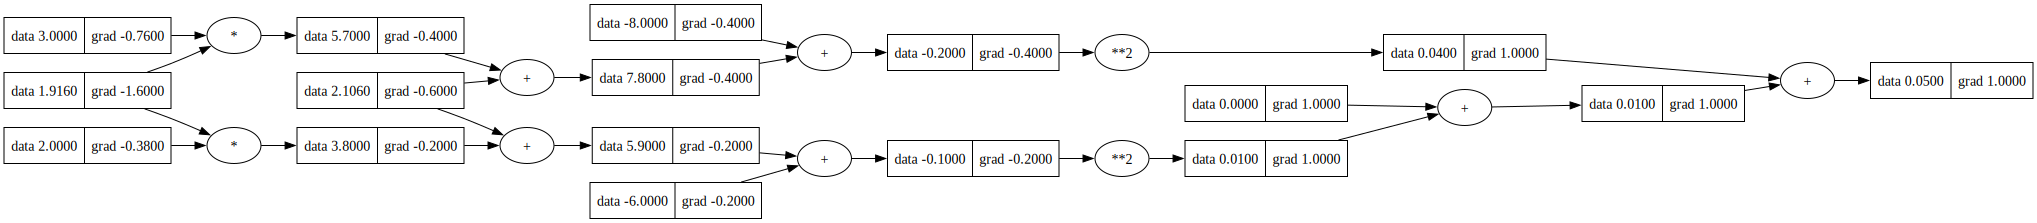

In [318]:
draw_dot(loss)

In [327]:
for i in range(100):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    n.zero_grad()
    loss.backward()
    for p in n.parameters():
        p.data -= p.grad * learning_rate
    print(loss, params[0].data, params[1].data)

Value(data=0.0009015119605279725, grad=1) 1.9582170159651522 2.1080761537513117
Value(data=0.0008990987650987032, grad=1) 1.9582729764390814 2.1079314060047443
Value(data=0.0008966920293864544, grad=1) 1.9583288619644459 2.1077868521206464
Value(data=0.0008942917360996833, grad=1) 1.9583846726416254 2.107642491839376
Value(data=0.000891897867993124, grad=1) 1.958440408570865 2.1074983249016386
Value(data=0.0008895104078676379, grad=1) 1.9584960698522764 2.1073543510484867
Value(data=0.0008871293385700723, grad=1) 1.9585516565858359 2.1072105700213197
Value(data=0.0008847546429934334, grad=1) 1.9586071688713866 2.1070669815618834
Value(data=0.0008823863040761257, grad=1) 1.958662606808638 2.1069235854122694
Value(data=0.0008800243048025034, grad=1) 1.9587179704971651 2.106780381314915
Value(data=0.0008776686282025762, grad=1) 1.9587732600364107 2.106637369012602
Value(data=0.0008753192573514458, grad=1) 1.9588284755256837 2.106494548248457
Value(data=0.0008729761753697405, grad=1) 1.958